In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms.v2 as tfs
import torch.nn as nn
from tqdm import tqdm
import json
import os
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class SunDataset(data.Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path , "train" if train else "test")
        self.transform = transform

        # Loading json file
        with open(os.path.join(self.path, "format.json"), 'r') as fp:
            self.format = json.load(fp)
        
        self.length = len(self.format)
        self.files = tuple(self.format.keys())
        self.targets = tuple(self.format.values())

    def __getitem__(self, item):
        path_file = os.path.join(self.path, self.files[item])
        img = Image.open(path_file).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(self.targets[item], dtype=torch.float32)
        
    def __len__(self):
        return self.length

# Creation of object data loader
transforms = tfs.Compose([tfs.ToImage(), tfs.ToDtype(torch.float32, scale=True)])
d_train = SunDataset("datasets\dataset_reg", transform=transforms)
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)

# input 256, 256
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # (batch, 32, 128, 128)
    nn.Conv2d(32, 8, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # (batch, 8,64,64)
    nn.Conv2d(8, 4, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # (batch, 4,32,32)
    nn.Flatten(), # (batch, 4096)
    nn.Linear(4096, 128),
    nn.ReLU(),
    nn.Linear(128,2)
)

optimizer = optim.Adam(params=model.parameters(), lr= 0.001, weight_decay=0.001)
loss_function= nn.MSELoss()

epochs = 5
model.to(device)
model.train()

for _e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count+=1
        loss_mean = 1/lm_count *loss.item() + (1 -1/lm_count)*loss_mean
        train_tqdm.set_description(f"Epoch {_e+1}/epochs{epochs}, loss_mean = {loss_mean:.3f}")


st = model.state_dict()
torch.save(st, 'model_sun.tar')

# Evaluation
d_test = SunDataset("datasets\dataset_reg",train=False, transform=transforms)
test_data = data.DataLoader(d_test, batch_size = 50, shuffle = False)

Q = 0 
count = 0
model.eval()

test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    with torch.no_grad():
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        p = model(x_test)
        Q += loss_function(p, y_test).item()
        count+=1
Q /= count
print(Q)


<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:95: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:95: SyntaxWarning: invalid escape sequence '\d'
C:\Users\pantu\AppData\Local\Temp\ipykernel_32716\3749460451.py:44: SyntaxWarning: invalid escape sequence '\d'
  d_train = SunDataset("datasets\dataset_reg", transform=transforms)
C:\Users\pantu\AppData\Local\Temp\ipykernel_32716\3749460451.py:95: SyntaxWarning: invalid escape sequence '\d'
  d_test = SunDataset("datasets\dataset_reg",train=False, transform=transforms)


Using device: cuda


100%|██████████| 20/20 [00:01<00:00, 10.86it/s]

8.68820071220398


Using device: cuda
tensor([[ 36.3040, 132.8284]], grad_fn=<AddmmBackward0>)


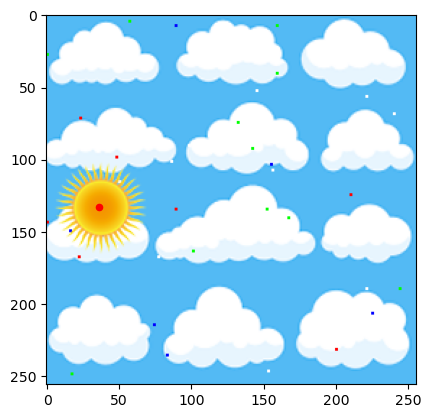

In [4]:
# Inference
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms.v2 as tfs
import torch.nn as nn
from tqdm import tqdm
import json
import os
from PIL import Image
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sd = torch.load('model_sun.tar')
model = model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # (batch, 32, 128, 128)
    nn.Conv2d(32, 8, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # (batch, 8,64,64)
    nn.Conv2d(8, 4, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # (batch, 4,32,32)
    nn.Flatten(), # (batch, 4096)
    nn.Linear(4096, 128),
    nn.ReLU(),
    nn.Linear(128,2)
)
model.load_state_dict(sd)

img_idx = 5

# Loading json file
with open(os.path.join("datasets\\dataset_reg\\test", "format.json"), 'r') as fp:
    format = json.load(fp)

# Creation of object data loader
transforms = tfs.Compose([tfs.ToImage(), tfs.ToDtype(torch.float32, scale=True)])
img = Image.open( os.path.join("datasets\\dataset_reg\\test",f"sun_reg_{img_idx}.png" )).convert('RGB')
img_t = transforms(img).unsqueeze(0)

model.eval()
predict = model(img_t)
print(predict)
p = predict.detach().squeeze().numpy()

plt.imshow(img)
plt.scatter(p[0], p[1], s=20, c='r')
plt.show()

In [7]:
img_t.shape

model2 = nn.Sequential(
    nn.Conv2d(3,32,3, padding='same'),
    nn.MaxPool2d(2)
)

test1 = model2(img_t)
test1.shape


torch.Size([1, 32, 128, 128])

In [ ]:
# 2
import torch
import torch.nn as nn

x = torch.rand(1, 16, 16) # тензор x в программе не менять

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(3,3),padding=1,bias=True,stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(32, 16, kernel_size=(3,3),padding=1,bias=True,stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(256, 5, bias=True)
)
predict = model(x.unsqueeze(0))

torch.Size([1, 5])

In [31]:
# 3 
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_digits
import torch


digits = load_digits()

# Признаки и целевые значения
_global_var_data_x = torch.tensor(digits.data, dtype=torch.float32).view(-1, 1, 8, 8)
_global_var_target = torch.tensor(digits.target, dtype=torch.int64)

# здесь продолжайте программу
ds = data.TensorDataset(_global_var_data_x, _global_var_target)
test_data = data.DataLoader(ds, batch_size=len(ds), shuffle=False)

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1,padding=1, bias=True),
    nn.ReLU(inplace=True), 
    nn.MaxPool2d(2,stride=2), # (bs, 32, 4, 4)
    nn.Conv2d(32, 16, kernel_size=3, stride=1,padding=1, bias=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,stride=2), # (bs, 16, 2, 2)
    nn.Flatten(),
    nn.Linear(64,10,bias=True)
)

# model.load_state_dict(_global_model_state)
model.eval()

x_test, y_test = next(iter(test_data))

with torch.no_grad():
    predict = model(_global_var_data_x)
    predict = torch.argmax(predict, dim=1)
    Q = torch.sum(predict.flatten() == y_test.flatten()).item()

Q /= len(ds)

In [10]:
# 4 
import torch
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import matplotlib.pyplot as plt

# здесь объявляйте класс ImageNormalize
class ImageNormalize(nn.Module):
    def forward(self, x):
        a, b = torch.min(x), torch.max(x)
        return (x - a) / (b - a)


# генерация образов выборки
total = 100 # размер выборки
H, W = 32, 32 # размер изображений
circle = torch.tensor([[0, 0, 0, 255, 255, 255, 255, 0, 0, 0],
                       [0, 255, 255, 255, 255, 255, 255, 255, 255, 0],
                       [0, 255, 255, 255, 255, 255, 255, 255, 255, 0],
                       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
                       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
                       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
                       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
                       [0, 255, 255, 255, 255, 255, 255, 255, 255, 0],
                       [0, 255, 255, 255, 255, 255, 255, 255, 255, 0],
                       [0, 0, 0, 255, 255, 255, 255, 0, 0, 0]], dtype=torch.float32)
Hc, Wc = circle.size()


def _generate_img(_H, _W, _Hc, _Wc, _x, _y, _circle, _tr): # вспомогательная функция
    img = torch.rand(_H, _W) * 20
    img[_x:_x+_Hc, _y:_y+Wc] = _circle
    return _tr(img.view(1, 1, _H, _W))


transform = ImageNormalize()# создайте объект класса ImageNormalize
data_y = torch.tensor([(torch.randint(0, H-Hc, (1, )), torch.randint(0, W-Wc, (1, ))) for _ in range(total)])
data_x = torch.cat([_generate_img(H, W, Hc, Wc, _x[0], _x[1], circle, transform) for _x in data_y], dim=0)

torch.manual_seed(1)
model = nn.Sequential(
    nn.Conv2d(1,16,5,stride=1,padding=2, bias=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,stride=2),
    nn.Conv2d(16,32, kernel_size=3,stride=1,padding=1,bias=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,stride=2),
    nn.Flatten(),
    nn.Linear(2048, 2, bias=True)
)
model.eval()
# здесь создавайте модель (обязательно сразу после команды torch.manual_seed(1))
# пропустите через модель выборку data_x
pred = model(data_x)
loss_func = nn.MSELoss()
Q = loss_func(pred,data_y.float()).item()  # вычислите величину потерь, используя функцию loss_func = nn.MSELoss()

In [ ]:
# 5
import torch
import torch.nn as nn

# здесь объявляйте класс модели
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1 = nn.Sequential(
                    nn.Conv2d(3, 16,kernel_size=3, stride=1, padding=1,bias=True),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, stride=2),
                    nn.Conv2d(16, 32,kernel_size=3, stride=1, padding=1,bias=True),
                    nn.ReLU(inplace=True),
                    nn.MaxPool1d(2,stride=2),
                    nn.Flatten() # (bs, 32, 4, 4)
                )
        
        self.net2 = nn.Sequential(
            nn.Linear(12, 64, bias=False),
            nn.Sigmoid(),
            nn.BatchNorm2d(64)
        )
        self.output = nn.Linear(576, 10)
    def forward(self, x1, x2):
        x1 = self.net1(x1)
        x2 = self.net2(x2)
        x = torch.cat([x1,x2],dim=1)
        x = self.output(x)
        return x


# тензоры data_img, data_x в программе не менять
batch_size = 32
data_img = torch.rand(batch_size, 3, 16, 16)
data_x = torch.rand(batch_size, 12)

# здесь продолжайте программу
model = MyModel()
model.eval()
predict = model(data_img, data_x)


ValueError: expected 4D input (got 2D input)

In [1]:
32*16

512